# Dicionário

*   Series_Title - título
*   Released_Year - Ano de lançamento
*   Certificate - Classificação
*   Runtime - Duração
*   Genre - Genero
*   IMDB_Rating (alvo) = Nota do IMDB
*   Overview = Overview do filme
*   Meta_score = Média ponderada de todas as críticas
*   Director – Diretor
*   Star1 - Ator/atriz #1
*   Star2 - Ator/atriz #2
*   Star3 - Ator/atriz #3
*   Star4 - Ator/atriz #4
*   No_of_Votes - Número de votos
*   Gross - Faturamento


# Importação de bibliotecas

In [1]:
pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from catboost import CatBoostRegressor, Pool, cv
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from __future__ import annotations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Analise da estrutura do dataset

A base de dados contém 999 registros e 16 colunas, 2 colunas numéricas inteiras, 2 colunas numéricas contínuas e 12 colunas categóricas/textuais.


Valores Ausentes:

* Certificate: 101 registros ausentes (~10%)

* Meta_score: 157 registros ausentes (~16%)

* Gross: 169 registros ausentes (~17%)

Possíveis influências das variáveis na avaliação:

* Gênero Pode impactar a avaliação de acordo com a popularidade e tendências do público em diferentes épocas. Além disso, gêneros distintos envolvem diferentes níveis de complexidade (uso de efeitos especiais, atuações complexas se for um drama e etc...)

* Ano de lançamento Reflete recursos disponíveis na época e influencia a quantidade de votos recebidos

* Classificação Pode afetar a nota por delimitar a amplitude do público atingido

* Tempo de duração Pode influenciar a retenção do público, mas provavelmente com impacto pequeno

* Overview Pode influenciar a captação de interesse mas provavelmente é um fraco preditor da avalição e mas sua análise requer PLN e nosso modelo será regressivo

* Diretor e elenco Podem impactar fortemente a qualidade percebida do filme e, consequentemente, sua avaliação

* índice (Unnamed) não tem impacto.

Filmes com maior número de votos tendem a ter notas mais estáveis e confiáveis, o Meta_score deve ser um forte preditor pois é baseado na média ponderada de críticas, o Gross pode ter impacto por inferência de popularidade, filmes com maior faturamento possivelmente agradaram um público maior.

In [3]:
df = pd.read_csv('desafio_indicium_imdb.csv')
df.head(5)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [4]:
df.describe()

,Unnamed: 0,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,999.000000,842.000000,9.990000e+02
mean,500.000000,7.947948,77.969121,2.716214e+05
std,288.530761,0.272290,12.383257,3.209126e+05
min,1.000000,7.600000,28.000000,2.508800e+04
25%,250.500000,7.700000,70.000000,5.547150e+04
50%,500.000000,7.900000,79.000000,1.383560e+05
75%,749.500000,8.100000,87.000000,3.731675e+05
max,999.000000,9.200000,100.000000,2.303232e+06


Como o min e max de IMDB_Rating e Meta_score estão dentro do padrão de 0 a 10 e 0 a 100, parece não haver números incorretos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Certificate, Meta_score e Gross apresentam números ausentes

In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
Series_Title,0
Released_Year,0
Certificate,101
Runtime,0
Genre,0
IMDB_Rating,0
Overview,0
Meta_score,157
Director,0


In [7]:
df['Genre'].value_counts()

,count
Genre,
Drama,84
"Drama, Romance",37
"Comedy, Drama",35
"Comedy, Drama, Romance",31
"Action, Crime, Drama",30
...,...
"Action, Adventure, Family",1
"Action, Crime, Mystery",1
"Animation, Drama, Romance",1


In [8]:
df['Released_Year'].value_counts().sort_index()

,count
Released_Year,
1920,1
1921,1
1922,1
1924,1
1925,2
...,...
2017,22
2018,19
2019,23


Há 1 registro incorreto em Released_Year

In [9]:
print(df[df['Released_Year'] == 'PG'])

     Unnamed: 0 Series_Title Released_Year Certificate  Runtime  \
965         966    Apollo 13            PG           U  140 min   

                         Genre  IMDB_Rating  \
965  Adventure, Drama, History          7.6   

                                              Overview  Meta_score  \
965  NASA must devise a strategy to return Apollo 1...        77.0   

       Director      Star1        Star2        Star3        Star4  \
965  Ron Howard  Tom Hanks  Bill Paxton  Kevin Bacon  Gary Sinise   

     No_of_Votes        Gross  
965       269197  173,837,933  


In [10]:
df.loc[df['Released_Year'] == 'PG', 'Released_Year'] = 1995
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce').astype('Int64')
print(df['Released_Year'].value_counts().sort_index())

Released_Year
1920     1
1921     1
1922     1
1924     1
1925     2
        ..
2016    28
2017    22
2018    19
2019    23
2020     6
Name: count, Length: 99, dtype: Int64


Como há apenas 1 registro que aparece essa inconsistência foi feito uma busca na internet para saber o ano de lançamento e corrigido no df

# Limpeza dos dados

In [11]:
#Retirando as Colunas irrelevantes
df_limpo = df.drop(['Unnamed: 0', 'Series_Title', 'Overview'], axis=1).copy()
df_limpo.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1972,A,175 min,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2008,UA,152 min,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,1974,A,202 min,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,1957,U,96 min,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,2003,U,201 min,"Action, Adventure, Drama",8.9,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [12]:
#Retirando as ',' e transformando a coluna em numerica
df_limpo['Gross'] = (df_limpo['Gross'].astype(str).str.replace(',', '', regex=False))
df_limpo['Gross'] = pd.to_numeric(df_limpo['Gross'], errors='coerce')
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Released_Year  999 non-null    Int64  
 1   Certificate    898 non-null    object 
 2   Runtime        999 non-null    object 
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Meta_score     842 non-null    float64
 6   Director       999 non-null    object 
 7   Star1          999 non-null    object 
 8   Star2          999 non-null    object 
 9   Star3          999 non-null    object 
 10  Star4          999 non-null    object 
 11  No_of_Votes    999 non-null    int64  
 12  Gross          830 non-null    float64
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 102.6+ KB


In [13]:
#Como já existe uma coluna de sem classificação vamos colocar os NaN nessa categoria tambem
df_limpo['Certificate'] = df_limpo['Certificate'].fillna('Unrated')
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Released_Year  999 non-null    Int64  
 1   Certificate    999 non-null    object 
 2   Runtime        999 non-null    object 
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Meta_score     842 non-null    float64
 6   Director       999 non-null    object 
 7   Star1          999 non-null    object 
 8   Star2          999 non-null    object 
 9   Star3          999 non-null    object 
 10  Star4          999 non-null    object 
 11  No_of_Votes    999 non-null    int64  
 12  Gross          830 non-null    float64
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 102.6+ KB


Como a quantidade de NaN é alta e desconhecemos as possíveis classificações foi feito uma substituição por uma nova categoria chamada de 'Desconhecido'

In [14]:
df_limpo["Runtime"] = (df["Runtime"].astype(str).str.replace("min", "", regex=False).str.strip())
df_limpo["Runtime"] = pd.to_numeric(df_limpo["Runtime"], errors="coerce")
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Released_Year  999 non-null    Int64  
 1   Certificate    999 non-null    object 
 2   Runtime        999 non-null    int64  
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Meta_score     842 non-null    float64
 6   Director       999 non-null    object 
 7   Star1          999 non-null    object 
 8   Star2          999 non-null    object 
 9   Star3          999 non-null    object 
 10  Star4          999 non-null    object 
 11  No_of_Votes    999 non-null    int64  
 12  Gross          830 non-null    float64
dtypes: Int64(1), float64(3), int64(2), object(7)
memory usage: 102.6+ KB


In [15]:
#Como o CatBoost não precisa eliminar os NaN iremos separar em 3 dfs
df_ridge = df_limpo.copy() #df para ser usada na regressão ridge
df_lasso = df_limpo.copy() #df para ser usada na regressão lasso
df_cat = df_limpo.copy() #df para ser usada na catboost
df_LN = df_limpo.copy() #df para ser usada na regressão linear

In [16]:
#A df_limpo continuara sendo usada aqui para se feito as análises uni e bi variadas
df_limpo['Meta_score'] = df_limpo['Meta_score'].fillna(df_limpo['Meta_score'].median())
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Released_Year  999 non-null    Int64  
 1   Certificate    999 non-null    object 
 2   Runtime        999 non-null    int64  
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Meta_score     999 non-null    float64
 6   Director       999 non-null    object 
 7   Star1          999 non-null    object 
 8   Star2          999 non-null    object 
 9   Star3          999 non-null    object 
 10  Star4          999 non-null    object 
 11  No_of_Votes    999 non-null    int64  
 12  Gross          830 non-null    float64
dtypes: Int64(1), float64(3), int64(2), object(7)
memory usage: 102.6+ KB


In [17]:
df_limpo['Gross'] = df_limpo['Gross'].fillna(df_limpo['Gross'].median())
df_limpo.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.0,999.000000,999.000000,999.000000,9.990000e+02,9.990000e+02
mean,1991.218218,122.871872,7.947948,78.131131,2.716214e+05,6.053338e+07
std,23.297166,28.101227,0.272290,11.373766,3.209126e+05,1.014694e+08
min,1920.0,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.0,103.000000,7.700000,72.000000,5.547150e+04,5.011838e+06
50%,1999.0,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07
75%,2009.0,137.000000,8.100000,85.500000,3.731675e+05,6.157656e+07
max,2020.0,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


Os NaN de Gross e Meta_sScore foram substituidos por suas medianas para não impactar o modelo caso tenha outliers

# Análise Univariada

**Resumo**

A análise univariada do conjunto de dados evidencia características importantes das variáveis e já antecipa alguns desafios para a etapa de modelagem. O Released_Year apresenta uma distribuição ampla, mas com poucos filmes anteriores a 1960, mostrando um crescimento consistente a partir dessa data, o que reflete a evolução da indústria cinematográfica e o boom observado nos anos 1980.

A variável IMDB_Rating mostra concentração marcante entre 7.6 e 8.0, com valores mínimos altos, o que indica que todos os filmes presentes no dataset são bem avaliados. Esse comportamento sugere que o IMDB tende a ser mais permissivo com notas medianas e mais rigoroso com notas muito altas, isso reduz a variabilidade do target e trazendo maior dificuldade para modelos preditivos diferenciarem os títulos.

No caso do Meta_score, a distribuição apresenta assimetria e picos atípicos, além de outliers expressivos.A variabilidade é razoável, permitindo análises mais ricas. A decisão de não tratar os outliers neste momento preserva a distribuição original, deixando ajustes para etapas posteriores da modelagem, caso necessário.

As variáveis No_of_Votes e Gross apresentam forte assimetria à direita, isso mostra um comportamento da indústria, poucos filmes atraem grandes bilheteiras e milhões de votos. Comercialmente, isso reforça a concentração do mercado em blockbusters. É necessário aplicar transformações logarítmicas ou normalizações para reduzir o impacto de outliers e evitar que os modelos sejam distorcidos por casos extremos.

A variável Runtime mostra concentração em torno de duas horas, confirmando o padrão da indústria cinematográfica. Filmes muito curtos ou muito longos são raros e nichados, como animações, curtas-metragens ou produções épicas. Embora a duração não reflita diretamente a avaliação do público, pode influenciar indiretamente, já que produções mais longas costumam estar associadas a maiores orçamentos e maior investimento em qualidade.

Em síntese, as análises univariadas revelam que o dataset é dominado por filmes bem avaliados, concentrados em dramas de longa duração, com forte assimetria em métricas de popularidade e faturamento. Esses padrões exigirão cuidados no pré-processamento, especialmente na transformação de variáveis, a fim de garantir maior robustez nos modelos preditivos.

**Obs**: Irei usar o plotly por ser visualmente melhor porem não é recomendavel usar em datasets grandes pois tem um custo de processamento muito alto


In [18]:
#Usando a função describe para investigar se o df não possui nenhuma irregularidade como notas acima de 10 ou abaixo de 1
df_limpo.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.0,999.000000,999.000000,999.000000,9.990000e+02,9.990000e+02
mean,1991.218218,122.871872,7.947948,78.131131,2.716214e+05,6.053338e+07
std,23.297166,28.101227,0.272290,11.373766,3.209126e+05,1.014694e+08
min,1920.0,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.0,103.000000,7.700000,72.000000,5.547150e+04,5.011838e+06
50%,1999.0,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07
75%,2009.0,137.000000,8.100000,85.500000,3.731675e+05,6.157656e+07
max,2020.0,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


Released_Year apresenta uma distribuição bastante ampla, iremos averiguar se os filmes mais antigos são dados válidos.
IMDB_Rating apresenta pouca variação, o que pode dificultar o desempenho do modelo preditivo.
Meta_score tem desvio padrão razoável e uma amplitude plausíveis, por isso eventuais outliers não serão tratados neste momento para não comprometer as análises e será tratado caso o modelo preditivo necessitar.
Tanto No_of_Votes quanto Gross apresentam forte assimetria, para mitigar esse efeito será aplicada uma transformação logarítmica antes da construção do modelo.

In [19]:
#Conferindo se os títulos mais antigos estão corretos
print(df[df['Released_Year'] < 1930]['Series_Title'])

125                       Metropolis
126                          The Kid
192                    The Gold Rush
193                     Sherlock Jr.
316       La passion de Jeanne d'Arc
317                       The Circus
318    Sunrise: A Song of Two Humans
319                      The General
320     Das Cabinet des Dr. Caligari
461             Bronenosets Potemkin
567                        Nosferatu
Name: Series_Title, dtype: object


Os filmes com o Released_Year < 1930 estão corretos

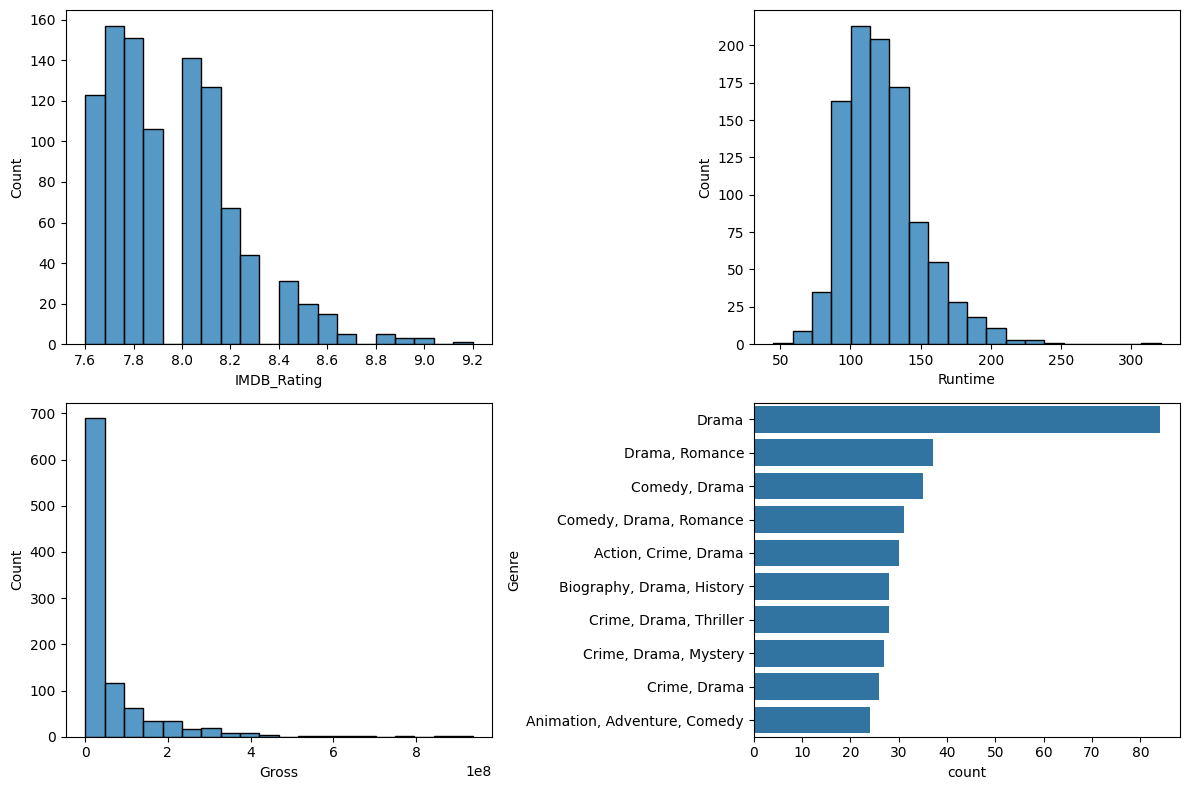

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.histplot(df_limpo["IMDB_Rating"], bins=20, ax=axes[0,0])
sns.histplot(df_limpo["Runtime"], bins=20, ax=axes[0,1])
sns.histplot(df_limpo["Gross"], bins=20, ax=axes[1,0])
sns.countplot(y=df_limpo["Genre"], order=df_limpo["Genre"].value_counts().index[:10], ax=axes[1,1])
plt.tight_layout()

O primeiro gráfico mostra a distribuição da variável IMDB_Rating, concentrada principalmente entre 7.6 e 8.2.Isso indica que os filmes presentes na base são bem avaliados, o que pode dificultar a diferenciação entre títulos, pois todos parecem partir de um patamar de qualidade alto. Do ponto de vista técnico, essa concentração reduz a variabilidade do target, o que pode limitar a capacidade de modelos preditivos em capturar padrões significativos.

O segundo gráfico mostra a distribuição do Runtime, com concentração em torno de 120 minutos e poucos casos extremos. Comercialmente, observa-se que o padrão da indústria de cinema é próximo a duas horas, mostrando que produções muito curtas ou muito longas são nichadas e menos frequentes. Tecnicamente, essa distribuição quase normal é positiva, pois facilita a modelagem e sugere que a variável pode ter correlação com a nota.

O terceiro gráfico, referente ao Gross, tem forte assimetria, com a maioria dos filmes faturando abaixo de 100M e poucos casos alcançando valores muito elevados. Comercialmente isso indica que a indústria do cinema tem poucos grandes sucessos financeiros e uma abundância de produções medianas. Tecnicamente, a presença de outliers tão expressivos pode distorcer métricas em modelos de regressão. Uma prática recomendada é aplicar transformações para reduzir a assimetria.

A variável Genre tem o predomínio de Drama e suas combinações com outros gêneros como Romance e Comédia. Comercialmente, isso evidencia uma preferência por dramas, possivelmente associadas à aceitação crítica e maior chance de prêmios, contudo isso pode indicar saturação, sugerindo que explorar outros gêneros menos frequentes pode ser uma oportunidade de mercado. O desequilíbrio na frequência dos gêneros gera risco de viés nos modelos, que podem aprender a associar automaticamente o Drama a notas mais altas, uma solução é aplicar codificação.

In [21]:
px.histogram(df_limpo, x='Released_Year', title='Distribuição - Released Year').show()
px.box(df_limpo, x='Released_Year', title='Boxplot - Released Year').show()

Há um número relativamente baixo de filmes anteriores a 1960, e um aumento consistente com os anos. Isso pode demonstrar o crescimento da indústria cinematográfica com passar dos anos com um boom de meados da década de 80

In [22]:
px.histogram(df_limpo, x='IMDB_Rating', title='Distribuição - IMDB Rating').show()
px.box(df_limpo, x='IMDB_Rating', title='Boxplot - IMDB Rating').show()

A maioria das avaliações concentradas entre 7.6 e 8.0. A nota mínima registrada é 7.6, o que indica que todos os filmes presentes no conjunto possuem uma avaliação positiva. Além disso, a distribuição indica que o IMDb tende a ser mais rigoroso com notas muito altas, ao mesmo tempo em que não penaliza com tanta severidade filmes medianos ou levemente abaixo da média.

In [23]:
px.histogram(df_limpo, x='Meta_score', title='Distribuição - Meta Score').show()
px.box(df_limpo, x='Meta_score', title='Boxplot - Meta Score').show()

A distribuição é assimétrica à direita com um pico incomum em 80, com uma boa variabilidade entre 60 e 90, o pico em 1980 provavelmente se deve a substituição dos NaN pela mediana, Além disso podemos dizer que entre os filmes avaliados poucos são considerados ruins

In [24]:
px.histogram(df_limpo, x='No_of_Votes', title='Distribuição - No of Votes').show()
px.box(df_limpo, x='No_of_Votes', title='Boxplot - No of Votes').show()

Há clara presença de outliers, necessitando de  uma normalização.

In [25]:
px.histogram(df_limpo, x='Gross', title='Distribuição - Gross').show()
px.box(df_limpo, x='Gross', title='Boxplot - Gross').show()

In [26]:
#Conferindo se os maiores outliers são reais
id_filme = df_limpo[df_limpo['Gross'] > 400_000_000].index
print(df.loc[id_filme, 'Series_Title'])

1                                 The Dark Knight
42                                  The Lion King
58                              Avengers: Endgame
59                         Avengers: Infinity War
62                          The Dark Knight Rises
150                                   Toy Story 3
261                                 Jurassic Park
356                                  The Avengers
476    Star Wars: Episode VII - The Force Awakens
581                                     Rogue One
582                    Captain America: Civil War
595                                   Toy Story 4
622                                        Avatar
651                                       Titanic
687                    E.T. the Extra-Terrestrial
890                                 Incredibles 2
Name: Series_Title, dtype: object


A grande assimetria se deve provavelmente a blockbusters e há a necessidade de normalização

In [27]:
px.histogram(df_limpo, x='Runtime', title='Distribuição - Runtime').show()
px.box(df_limpo, x='Runtime', title='Boxplot - Runtime').show()

É possível identificar que a maioria das produções se concentra no intervalo entre 90 e 130 minutos, o que é normal para a maioria dos filmes. A média é próxima de 120 minutos, enquanto a mediana gira em torno de 110 minutos. Os filmes curtos podem ser curta-metragem, animações ou filmes mais antigos que costumavam ser mais curtos e os muito longe podem ser blockbusters, apesar de o tempo de exibição não ser um fator que impacta diretamente na nota, pode impactar indiretamente pois filmes mais longos costumam ser filmes com maior orçamento e por sua vez ter maior investimento

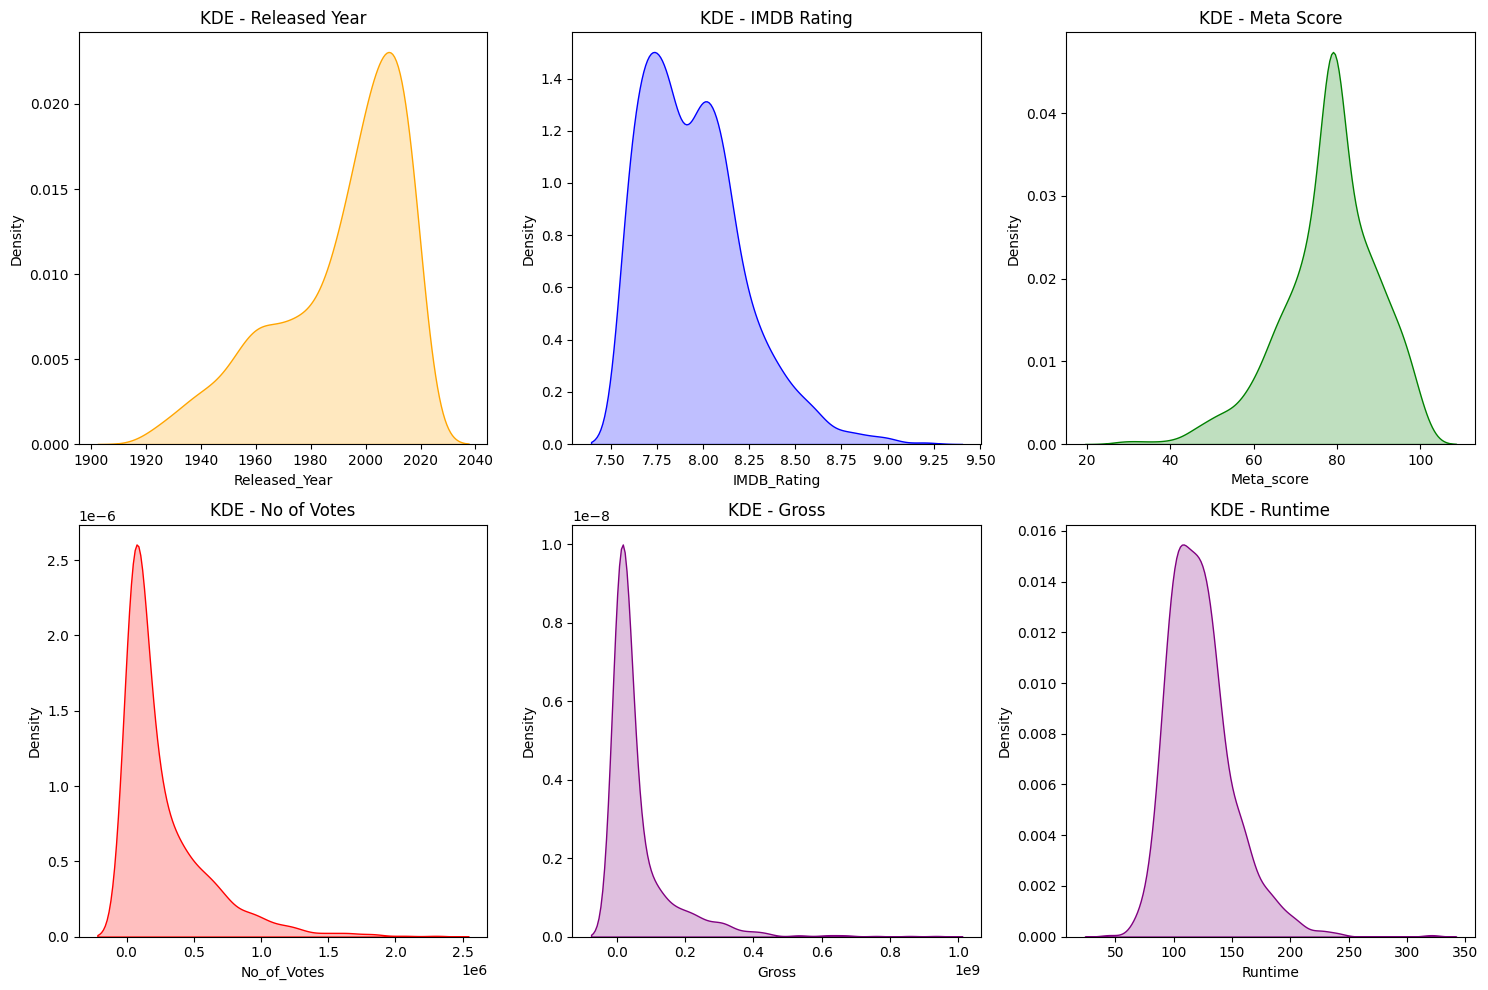

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.kdeplot(df_limpo['Released_Year'], shade=True, color='orange')
plt.title('KDE - Released Year')

plt.subplot(2, 3, 2)
sns.kdeplot(df_limpo['IMDB_Rating'], shade=True, color='blue')
plt.title('KDE - IMDB Rating')

plt.subplot(2, 3, 3)
sns.kdeplot(df_limpo['Meta_score'], shade=True, color='green')
plt.title('KDE - Meta Score')

plt.subplot(2, 3, 4)
sns.kdeplot(df_limpo['No_of_Votes'], shade=True, color='red')
plt.title('KDE - No of Votes')

plt.subplot(2, 3, 5)
sns.kdeplot(df_limpo['Gross'], shade=True, color='purple')
plt.title('KDE - Gross')

plt.subplot(2, 3, 6)
sns.kdeplot(df_limpo['Runtime'], shade=True, color='purple')
plt.title('KDE - Runtime')


plt.tight_layout()
plt.show()

Os gráficos de densidade confirmam as análises anteriores

# Análise Bivariada

**Resumo**

A análise bivariada do conjunto de dados permitiu explorar como diferentes variáveis se relacionam com a nota do IMDB e entre si. De maneira geral, observou-se que as correlações não são muito fortes, mas há alguns padrões importantes. O número de votos se mostrou o fator mais relevante, com uma relação positiva moderada com a nota do IMDB e forte correlação com o faturamento. Isso sugere que a popularidade de um filme exerce papel central no reconhecimento da obra.

Em contraste, variáveis como a avaliação da crítica especializada, mostraram apenas uma correlação fraca com a nota do público. Essa diferença indica que filmes bem avaliados por críticos nem sempre são valorizados pelo população comum, refletindo a diferença entre prestígio artístico e apelo popular. Além disso, filmes mais antigos tendem a ter notas de crítica mais altas, possivelmente em razão de serem clássicos ou por conta da valorização histórica, embora esse efeito não reflita maiores notas no IMDB.

Outras variáveis, como o faturamento bruto e o ano de lançamento, apresentaram relações muito fracas com a nota, reforçando a ideia de que sucesso comercial e temporalidade não são bons preditores da qualidade percebida pelo público. A certificação revelou pequenas diferenças na distribuição das notas, mas sem mudanças drásticas.

A análise bivariada evidencia que o engajamento popular é o fator mais associado à nota do IMDB, enquanto elementos como crítica especializada, faturamento e ano de lançamento desempenham papéis secundários. Essa visão fornece uma base para a modelagem preditiva e para interpretações de negócio, destacando que estratégias de mercado que aumentem o alcance e a participação do público tendem a ser mais eficazes do que simplesmente investir em orçamentos ou depender de reconhecimento crítico.

In [29]:
df_limpo.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1972,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,2008,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,1974,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,1957,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,2003,U,201,"Action, Adventure, Drama",8.9,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [30]:
px.scatter(df_limpo, x='Meta_score', y='IMDB_Rating', title='Meta Score vs IMDB Rating', trendline='ols', opacity=0.6).show()

Ao analisar a dispersão, observa-se uma tendência positiva relativamente fraca, inicialmente pensamos que a Meta_Score teria alta correlação com o target mas isso se mostrou não ser verdadeiro, talvez isso se deve, como vimos anteriormente, pelo fato que talvez o IMDB seja menos rígido para dar notas baixas e mais rígida notas altas (amplitude de 7,6 a 8,7 com alguns outliers acima disso) enquanto a análise crítica é mais rígida com notas menores e menos com notas maiores (amplitude de 52 a 100 com vários outliers abaixo de 52)

In [31]:
px.scatter(df_limpo, x='Gross', y='IMDB_Rating', title='Gross vs IMDB Rating', trendline='ols', opacity=0.6).show()

Gross em teoria, poderia estar relacionada a qualidade percebida pelo público. Ao analisar a dispersão entre Gross e IMDB Rating, observa-se uma tendência levemente positiva, mas extremamente fraca, o que contraria nossa hipótese inicial. Um dos possíveis principais motivos é o marketing e a época em que foram lançados pois antigamente a indústria cinematográfica não era tão amplamente distribuída e nem tão popular quanto hoje

In [32]:
px.scatter(df_limpo, x='No_of_Votes', y='IMDB_Rating', title='No. of Votes vs IMDB Rating', trendline='ols', opacity=0.6).show()

Ao analisar sua relação com o IMDB Rating, observa-se uma tendência positiva mais clara do que a verificada com o Gross, porem com alta dispersão. Isso possivelmente se deve ao fato que filmes mais avaliados tendem a ter uma avaliação mais estável

In [33]:
px.scatter(df_limpo, x='Released_Year', y='IMDB_Rating', title='Released Year vs IMDB Rating', trendline='ols', opacity=0.6).show()

observa-se que a tendência geral é praticamente neutra, com uma linha de regressão quase horizontal. Isso indica que o ano em que o filme foi lançado, por si só, não exerce uma influência determinante na nota.

In [34]:
px.scatter(df_limpo, x='Runtime', y='IMDB_Rating', title='Runtime vs IMDB Rating', trendline='ols', opacity=0.6).show()

Observa-se uma tendência levemente positiva, ainda que bastante dispersa, o que bate com o que foi comentado anteriormente nas análises univariadas, porem o que não era esperado era que ela iria ter uma correlação similar as outras variáveis

In [35]:
px.box(df_limpo, x='Certificate', y='IMDB_Rating', title='Distribuição do IMDB Rating por Certificate').show()

Certificate mostra diferenças sutis nas notas do IMDB. Categorias como A, UA e PG-13 concentram a maioria dos filmes, com medianas próximas de 7,8–8,0, indicando estabilidade nas avaliações. Já certificações como R e Unrated apresentam maior dispersão. As categorias  TV-14, TV-MA, 16 mostram distribuições intermediárias

<Axes: >

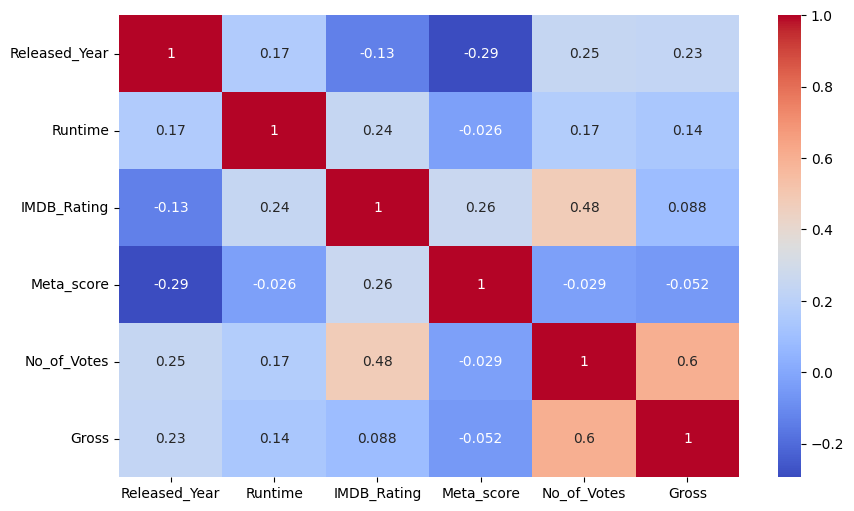

In [36]:
corr = df_limpo.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")

A matriz de correlação mostra relações interessantes entre as variáveis numéricas do conjunto de dados, mas a maioria das associações não são muito fortes. Observa-se uma correlação positiva moderada entre a IMDB_Rating e o No_of_Votes, em torno de 0.48. Isso achado sugere que quanto mais pessoas assistem a um filme e participam ativamente da votação no IMDB, maior tende a ser sua avaliação. Tal efeito pode ser por contas do “efeito popularidade”. O resultado indica que o número de votos deve ser considerado uma das variáveis mais relevantes para prever a nota de um filme.

Outro ponto de destaque é a forte correlação entre Gross e o número de votos, em torno de 0.60. A explicação é bastante intuitiva, filmes com grandes bilheteiras tendem a ter um maior público engajado e, por sua vez, mais votos no IMDB. Tal associação indica a presença de possível multicolinearidade, especialmente em modelos lineares, já que tanto Gross quanto votos capturam aspectos semelhantes. Nesse caso, o uso de modelos baseados em árvores, como o CatBoost, pode ser vantajoso por lidarem melhor com redundâncias entre variáveis.

Já a relação entre IMDB_Rating e Meta_score apresenta correlação positiva baixa, em torno de 0.26. Esse resultado mostra uma diferença entre crítica especializada e opinião do público, nem sempre um filme bem avaliado por críticos tem bom reconhecimento popular. Comercialmente, isso sugere que estúdios devem ter estratégias diferenciadas dependendo do objetivo, prestígio em festivais e prêmios ou apelo junto ao grande público. O Meta_score pode contribuir como variável preditiva, mas não considerado determinante.

Um aspecto interessante é a correlação negativa entre Released_Year e o Meta_score, em torno de -0.29. Isso indica que filmes mais antigos tendem a apresentar avaliações críticas mais altas, possivelmente por serem clássicos, produções renomadas que resistiram ao tempo ou saudosismo.

Por fim, a relação entre Gross e IMDB_Rating é muito fraca, próxima de 0.09, o que significa, pelo menos dentro do contexto desse dataset, que alto faturamente não significa ser bem avaliado. Isso confirma que grandes blockbusters podem ter enorme apelo financeiro, mas sem garantias de qualidade percebida.

Resumidamente, a análise da correlação mostra que a popularidade, medida pelo número de votos, é o fator mais importante tanto para explicar a nota do IMDB quanto o faturamento. Crítica especializada e a temporalidade dos filmes exercem influência menor, porém relevante. Essa visão integrada reforça que estratégias que ampliem a base de espectadores são mais eficazes para elevar tanto receita quanto reconhecimento popular, mesmo que não melhorem necessariamente a avaliação crítica.

# Modelagem

Foram testados quatro algoritmos distintos para prever a nota do IMDB: Regressão Linear, Ridge, Lasso e CatBoost. Os resultados foram avaliados por meio das métricas MAE, RMSE e R^2. De forma geral, os modelos lineares apresentaram desempenhos bastante próximos, com valores de R^2 baixos, variando em torno de 0.11 a 0.17. Isso indica que tais modelos conseguem explicar apenas uma pequena parte da variabilidade do target, o que era esperado dado que a distribuição da nota no IMDB apresenta baixa variabilidade. Entre os lineares, o Ridge apresentou o menor RMSE, mostrando-se um pouco mais robusto ao lidar com multicolinearidade, mas com muitas limitações. O CatBoost obteve o melhor desempenho entre todos os modelos testados, alcançando R^2 em torno de 0.41 no teste, na CV uma média de 0,53 e métricas de erro menores que os modelos lineares. Esse resultado reforça a adequação de algoritmos baseados em árvores de decisão para este tipo de problema, além disso, o CatBoost tem a vantagem de lidar de forma mais eficiente com variáveis categóricas e valores ausentes, o que é muito útil neste dataset, que contém variáveis como Genre, Certificate, Director e Stars.

Diante disso, o modelo final escolhido foi o CatBoost, pois apresentou desempenho consistentemente superior, maior capacidade de generalização e maior flexibilidade em relação ao pré-processamento. Sua utilização elimina a necessidade de extensas codificações manuais, evita problemas de multicolinearidade e oferece melhor adaptação às características do conjunto de dados analisado.

## CatBoost

Como o CatBoost possui tratamento nativo para valores ausentes e variáveis categóricas, treinarei o modelo em um dataset separado com pré-processamento mínimo, preservando os NaNs e evitando transformações que gerem viés. Essa separação evita Data leakeage e preserva o desempenho do modelo.

Obs: Essa é a primeira vez que uso CatBoost pois queria um modelo que não tivesse problemas com tantas categorias e achei ele em minhas pesquisas

In [37]:
print(df_cat.head())
print(df_cat.info())
print(df_cat.describe())

   Released_Year Certificate  Runtime                     Genre  IMDB_Rating  \
0           1972           A      175              Crime, Drama          9.2   
1           2008          UA      152      Action, Crime, Drama          9.0   
2           1974           A      202              Crime, Drama          9.0   
3           1957           U       96              Crime, Drama          9.0   
4           2003           U      201  Action, Adventure, Drama          8.9   

   Meta_score              Director           Star1            Star2  \
0       100.0  Francis Ford Coppola   Marlon Brando        Al Pacino   
1        84.0     Christopher Nolan  Christian Bale     Heath Ledger   
2        90.0  Francis Ford Coppola       Al Pacino   Robert De Niro   
3        96.0          Sidney Lumet     Henry Fonda      Lee J. Cobb   
4        94.0         Peter Jackson     Elijah Wood  Viggo Mortensen   

           Star3          Star4  No_of_Votes        Gross  
0     James Caan   Diane K

In [38]:
X = df_cat.drop(columns=["IMDB_Rating"]).copy()
y = df_cat["IMDB_Rating"].copy()

#CatBoost exige que as categoricas sejam strings mas as numericas podem continuar com nan
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
if len(cat_cols) > 0:
    X[cat_cols] = X[cat_cols].fillna("NA").astype(str)

#  Aplicar log-transform nas variáveis muito assimétricas
if "No_of_Votes" in X.columns:
    X["No_of_Votes"] = np.log1p(X["No_of_Votes"])

if "Gross" in X.columns:
    X["Gross"] = np.log1p(X["Gross"])


#Separação de treino, validação e teste para evitar leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, shuffle=True)

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_cols)

train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
valid_pool = Pool(X_val, y_val, cat_features=cat_cols)
test_pool  = Pool(X_test, y_test, cat_features=cat_cols)



In [39]:
params = dict(
    iterations=800,
    depth=6,
    learning_rate=0.07,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100,
    use_best_model=True,
    od_type="Iter",
    od_wait=100,
    l2_leaf_reg=5.0,
    subsample=0.8,
    colsample_bylevel=0.8
)

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=valid_pool)


pred_hold = model.predict(test_pool)
mse_hold  = mean_squared_error(y_test, pred_hold)
rmse_hold = float(np.sqrt(mse_hold))
mae_hold  = mean_absolute_error(y_test, pred_hold)
r2_hold   = r2_score(y_test, pred_hold)

print("=== Hold-out (TEST) ===")
print(f"RMSE: {rmse_hold:.4f}")
print(f"MAE : {mae_hold:.4f}")
print(f"R2  : {r2_hold:.4f}")

0:	learn: 0.2659468	test: 0.2968432	best: 0.2968432 (0)	total: 51.6ms	remaining: 41.2s
100:	learn: 0.1479312	test: 0.1994156	best: 0.1994156 (100)	total: 1.05s	remaining: 7.28s
200:	learn: 0.1184732	test: 0.1930059	best: 0.1929801 (199)	total: 2.27s	remaining: 6.76s
300:	learn: 0.1011613	test: 0.1913145	best: 0.1913145 (300)	total: 4.34s	remaining: 7.2s
400:	learn: 0.0882882	test: 0.1907043	best: 0.1905597 (356)	total: 5.62s	remaining: 5.59s
500:	learn: 0.0784994	test: 0.1901561	best: 0.1898295 (489)	total: 6.67s	remaining: 3.98s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1898295339
bestIteration = 489

Shrink model to first 490 iterations.
=== Hold-out (TEST) ===
RMSE: 0.1966
MAE : 0.1539
R2  : 0.4114


In [40]:
#Validação

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores, mae_scores, r2_scores = [], [], []
for i, (tr_idx, va_idx) in enumerate(kfold.split(X), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    tr_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
    va_pool = Pool(X_va, y_va, cat_features=cat_cols)

    m = CatBoostRegressor(**{**params, **{"verbose": False}})
    m.fit(tr_pool, eval_set=va_pool)

    pred_va = m.predict(va_pool)
    rmse = float(np.sqrt(mean_squared_error(y_va, pred_va)))
    mae  = mean_absolute_error(y_va, pred_va)
    r2   = r2_score(y_va, pred_va)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {i:>2} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

print("\n=== 5-Fold CV (média ± desvio) ===")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"R2  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Fold  1 | RMSE: 0.1960 | MAE: 0.1507 | R2: 0.4149
Fold  2 | RMSE: 0.1771 | MAE: 0.1416 | R2: 0.6573
Fold  3 | RMSE: 0.1909 | MAE: 0.1503 | R2: 0.4983
Fold  4 | RMSE: 0.1681 | MAE: 0.1346 | R2: 0.5327
Fold  5 | RMSE: 0.1756 | MAE: 0.1383 | R2: 0.5882

=== 5-Fold CV (média ± desvio) ===
RMSE: 0.1816 ± 0.0103
MAE : 0.1431 ± 0.0064
R2  : 0.5383 ± 0.0819


In [41]:
#Modelo final para predição do filme pedido no doc
best_trees = getattr(model, "tree_count_", None)  # nº de árvores efetivamente usadas
iters = best_trees if (best_trees is not None and best_trees > 0) else 800

full_pool = Pool(X, y, cat_features=cat_cols)
final_model_cat = CatBoostRegressor(
    iterations=iters,
    depth=6,
    learning_rate=0.07,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=False,
    use_best_model=False,
    l2_leaf_reg=5.0,
    subsample=0.8,
    colsample_bylevel=0.8
)
final_model_cat.fit(full_pool)

## Regressão Ridge

In [42]:
df_ridge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Released_Year  999 non-null    Int64  
 1   Certificate    999 non-null    object 
 2   Runtime        999 non-null    int64  
 3   Genre          999 non-null    object 
 4   IMDB_Rating    999 non-null    float64
 5   Meta_score     842 non-null    float64
 6   Director       999 non-null    object 
 7   Star1          999 non-null    object 
 8   Star2          999 non-null    object 
 9   Star3          999 non-null    object 
 10  Star4          999 non-null    object 
 11  No_of_Votes    999 non-null    int64  
 12  Gross          830 non-null    float64
dtypes: Int64(1), float64(3), int64(2), object(7)
memory usage: 102.6+ KB


In [43]:
X = df_ridge.drop(columns=["IMDB_Rating"]).copy()
y = df_ridge["IMDB_Rating"].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#imputação de NaN
num_impute = ["Gross", "Meta_score"]
for c in num_impute:
    if c in X_train.columns:
        med = X_train[c].median()
        X_train.loc[:, c] = X_train[c].fillna(med)
        X_test.loc[:,  c] = X_test[c].fillna(med)

# Transformação log1p
for c in ["Gross", "No_of_Votes"]:
    if c in X_train.columns:
        X_train.loc[:, c] = np.log1p(X_train[c])
        X_test .loc[:, c] = np.log1p(X_test[c])

#Criando dummies para as colunas categóricas
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test,  drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

model = Ridge(alpha=10.0, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Alpha usado: {model.alpha}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

Alpha usado: 10.0
MSE : 0.0533
RMSE: 0.2310
R²  : 0.1873


## Regressão Lasso

In [44]:
X = df_lasso.drop(columns=["IMDB_Rating"]).copy()
y = df_lasso["IMDB_Rating"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Imputação
num_impute = ["Gross", "Meta_score"]
for c in num_impute:
    if c in X_train.columns:
        med = X_train[c].median()
        X_train.loc[:, c] = X_train[c].fillna(med)
        X_test.loc[:,  c] = X_test[c].fillna(med)

# Transformação log1p
for c in ["Gross", "No_of_Votes"]:
    if c in X_train.columns:
        X_train.loc[:, c] = np.log1p(X_train[c])
        X_test .loc[:, c] = np.log1p(X_test[c])

# Criando dummies
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test,  drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

# PADRONIZAÇÃO
scaler = StandardScaler(with_mean=False)
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

model = Lasso(alpha=0.01, max_iter=10000)
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)

mse  = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
r2   = r2_score(y_test, y_pred)

print(f"Alpha usado: {model.alpha}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


Alpha usado: 0.01
MSE : 0.0530
RMSE: 0.2302
R²  : 0.1927


## Regressão Linear

In [45]:
X = df_LN.drop(columns=["IMDB_Rating"]).copy()
y = df_LN["IMDB_Rating"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)



#Imputação de NaN
for c in ["Gross", "Meta_score"]:
    if c in X_train.columns:
        med = X_train[c].median()
        X_train.loc[:, c] = X_train[c].fillna(med)
        X_test.loc[:,  c] = X_test[c].fillna(med)

#Transformção log1p
for c in ["Gross", "No_of_Votes"]:
    if c in X_train.columns:
        X_train.loc[:, c] = np.log1p(X_train[c])
        X_test.loc[:,  c] = np.log1p(X_test[c])

#Criando dummies
X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test,  drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
r2   = r2_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 0.0579
RMSE: 0.2407
R²  : 0.1176


## Comparação

In [46]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=1.0, random_state=42),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "CatBoost": CatBoostRegressor(
        depth=6,
        learning_rate=0.1,
        iterations=500,
        random_state=42,
        verbose=0
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

df_results = pd.DataFrame(results).T
print(df_results)

                       MAE      RMSE        R2
LinearRegression  0.187480  0.240669  0.117645
Lasso             0.204603  0.249812  0.049324
Ridge             0.185747  0.236734  0.146256
CatBoost          0.148402  0.195240  0.419315


# Resultados

Este estudo teve como objetivo prever a nota IMDB_Rating a partir de atributos de filmes presentes no dataset fornecido. Após a padronização de tipos, tratamos as ausências de forma simples e estruturamos as variáveis de acordo com o modelo. Mantivemos as variáveis categóricas como strings para o CatBoost e aplicamos one-hot encoding nos modelos lineares. Como Gross e No_of_Votes são assimétricas, aplicamos log1p nos lineares para estabilizar as escalas. A avaliação combinou hold-out 80/20 e validação cruzada 5-fold, reduzindo a dependência de um único corte amostral e permitindo estimar a variabilidade do erro.

A exploração inicial indicou que No_of_Votes e Meta_score são os preditores mais consistentes do rating. Observou-se também papel relevante de Released_Year e variações por Genre e Certificate. Já Gross apresentou relação mais fraca com a nota, condizente com o fato de a bilheteria refletir sobretudo ações de marketing e o contexto da indústria cinematográfica.

Nos resultados de modelagem, o CatBoost apresentou o melhor desempenho, capturando interações e não linearidades entre variáveis. No teste hold-out (20%), obteve RMSE ≈ 0,195 e R² ≈ 0,419; na validação cruzada 5-fold, RMSE ≈ 0,184 (± 0,011) e R² ≈ 0,528 (± 0,084), sugerindo estabilidade dos ganhos ao trocar os subconjuntos de treino e validação. Entre os baselines, o Lasso e o Ridge foram os mais competitivos, enquanto a Regressão Linear apresentara desempenho inferior, reforçando a vantagem de modelos capazes de acomodar relações não lineares e alta cardinalidade categórica.

# Instruções e Requesitos do desafio

# 1. Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses relacionadas. Seja criativo!

Foi feito durante o desenvolvimento do projeto, presente em analise univariada e bivariada


# 2. Responda também às seguintes perguntas:


## a. Qual filme você recomendaria para uma pessoa que você não conhece?


Quando não sabemos a preferência da pessoa, o melhor a se fazer é procurar o filme com muitas notas, para ser confiável, um certificado mais abrangente (U, UA, U/A, PG, PG-13, G, GP, Approved, Passed, TV-PG e TV-14) e apelo a gêneromais universal.

avaliação ponderada = ((votos/(votos + limiar de votos))*nota do filme) + ((limiar dos votos/(votos +limiar dos votos))*média global do conjunto)

No caso seria the dark knight

In [47]:
permitido = {"U", "UA", "U/A", "PG", "PG-13", "G", "GP", "Approved", "Passed", "TV-PG", "TV-14"} #Indicações livre

df_indicacao = df.dropna(subset=["IMDB_Rating", "No_of_Votes"]).copy() #Não vamos considerar variáveis desconhecidas

media = df_indicacao["IMDB_Rating"].mean() #Média global
limiar = np.percentile(df_indicacao["No_of_Votes"], 80) #80º percentil de votos

cand = df_indicacao[df_indicacao["No_of_Votes"] >= limiar].copy() #Cadidatos dentro do llimiar
cand = cand[cand["Certificate"].isin(permitido)].copy() #Dentre os candidatos dentro do limiar vamos selecionar os que possuem indicação livre

def Avaliacao_Ponderada(row, limiar, media):
    votos = row["No_of_Votes"]
    nota = row["IMDB_Rating"]
    return (votos / (votos + limiar)) * nota + (limiar / (votos + limiar)) * media

cand["AP"] = cand.apply(Avaliacao_Ponderada, axis=1, limiar=limiar, media=media)

cols_out = ["Series_Title", "Released_Year", "Certificate", "Genre", "IMDB_Rating", "No_of_Votes", "AP"]
top = (cand.sort_values("AP", ascending=False).loc[:, cols_out].reset_index(drop=True))

print(f"Média global (media): {media:.3f}")
print('+++++++++++++++++++++++++++++++++++')
print(f"Limiar de votos (limiar, 80º pct): {limiar:,.0f}\n")
print('+++++++++++++++++++++++++++++++++++')
print("Top 10:")
print(top.head(10).to_string(index=False, formatters={"AP": "{:.5f}".format}))

if not top.empty:
    rec = top.iloc[0]
    print("\nRecomendação principal:")
    print(f"\nTitulo: {rec['Series_Title']}")
    print(f"\nAno: {rec['Released_Year']}")
    print(f"\nClassificação: {rec['Certificate']}")
    print(f"\nAvaliação Ponderada: {rec['AP']:.3f}")
    print(f"\nNota IMDb: {rec['IMDB_Rating']}")
    print(f"\nVotos: {int(rec['No_of_Votes']):,}")
else:
    print("\nNenhum título atende aos critérios. Considere ajustar certificados ou o percentil do limiar.")


Média global (media): 7.948
+++++++++++++++++++++++++++++++++++
Limiar de votos (limiar, 80º pct): 461,995

+++++++++++++++++++++++++++++++++++
Top 10:
                                     Series_Title  Released_Year Certificate                      Genre  IMDB_Rating  No_of_Votes      AP
                                  The Dark Knight           2008          UA       Action, Crime, Drama          9.0      2303232 8.82423
    The Lord of the Rings: The Return of the King           2003           U   Action, Adventure, Drama          8.9      1642758 8.69102
                                        Inception           2010          UA  Action, Adventure, Sci-Fi          8.8      2067042 8.64435
                                     Forrest Gump           1994          UA             Drama, Romance          8.8      1809221 8.62668
The Lord of the Rings: The Fellowship of the Ring           2001           U   Action, Adventure, Drama          8.8      1661481 8.61462
                    

## b. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?


1. Certificate O boxplot entre Gross e Certificate mostra que filmes com certificações mais amplas, como "UA" e "U", tendem a ter uma média de faturamento mais alta. Isso faz sentido já que são filmes acessíveis a um público mais amplo, incluindo crianças e famílias, o que naturalmente amplia a bilheteria. Já filmes com classificação R ou Unrated, apesar de alguns terem faturamento alto, mostram maior variabilidade e, em geral, têm faturamento mais baixo na média. Isso sugere que restrições de faixa etária podem limitar o público e, portanto, a receita.

2. No_of_Votes No gráfico de dispersão entre Gross e No_of_Votes, há uma correlação clara e positiva. Quanto mais votos um filme recebe, maior tende a ser o seu faturamento. Esse padrão indica que filmes mais populares tendem a gerar maior receita. Isso também pode refletir investimentos maiores em marketing ou distribuição global.

3. Runtime Apesar de a relação ser mais fraca, há uma leve tendência de que filmes com maior tempo de duração tenham um pequeno aumento no faturamento médio. Isso pode estar associado a filmes de maior sucesso que muitas vezes tem maior duração, por exemplo, the avengers.

4. Ano de lançamento (Released_Year) O gráfico de dispersão entre Gross e Released_Year mostra que filmes mais recentes tendem a ter maior faturamento. Isso pode ser explicado por inflação, expansão dos mercados cinematográficos internacionais, mudanças nos hábitos de consumo e geolocalização, como por exemplo filmes hollywoodianos costumam ser mais amplamente divulgados.

5. Meta Score (Meta_score) e IMDB Rating Esses dois fatores apresentam uma correlação fraca com o faturamento, mas ainda assim relevante. Filmes com boas avaliações de Meta Score e IMDB Rating têm maior chance de sucesso comercial, apesar de podermos deduzir isso por lógica talvez não seja refletido pelo fato de algumas dessas obras terem sido feitas em épocas menos inflacionadas ou com menor expansão do mercado cinematográfico.

Os principais fatores que influenciam o gross são suas certificações mais amplas e alto numero de votos. Ano de lançamento e duração também influenciam (quanto mais recente e maior melhor), apesar das avaliações não impactarem tanto, talvez eles teriam um impacto maior se não houvesse outros fatores econômicos e de desenvolvimento da industrial Além disso apesar de não ser apresentado esses dados no nosso dataset podemos inferir que fatores como marketing, inflação, desenvolvimento e cultura da época podem influenciar.

In [48]:
df_limpo.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1972,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,2008,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,1974,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,1957,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,2003,U,201,"Action, Adventure, Drama",8.9,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


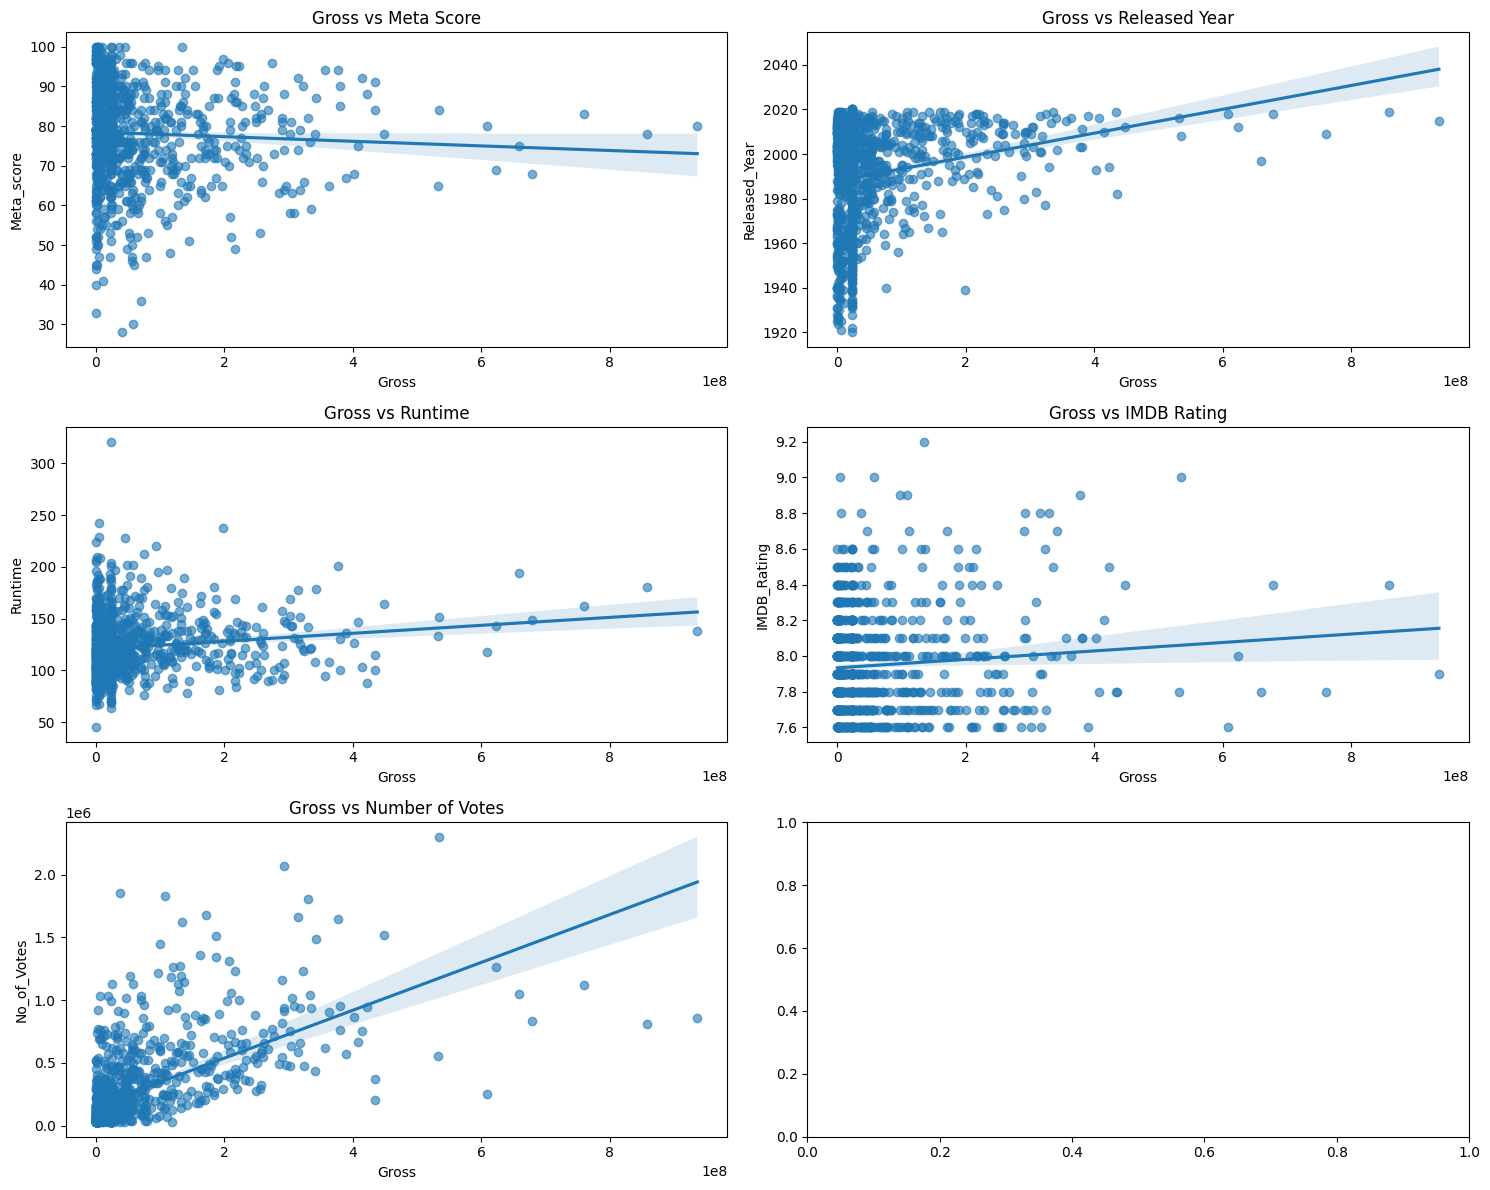

In [49]:
pares = [
    ("Meta_score",    "Gross vs Meta Score"),
    ("Released_Year", "Gross vs Released Year"),
    ("Runtime",       "Gross vs Runtime"),
    ("IMDB_Rating",   "Gross vs IMDB Rating"),
    ("No_of_Votes",   "Gross vs Number of Votes"),
]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (ycol, titulo) in enumerate(pares):
    x = pd.to_numeric(df_limpo["Gross"], errors="coerce")
    y = pd.to_numeric(df_limpo[ycol], errors="coerce")
    m = np.isfinite(x) & np.isfinite(y)
    sns.regplot(x=x[m], y=y[m], ax=axes[i], scatter_kws={"alpha": 0.6})
    axes[i].set_title(titulo)
    axes[i].set_xlabel("Gross")
    axes[i].set_ylabel(ycol)


fig.tight_layout()
plt.show()


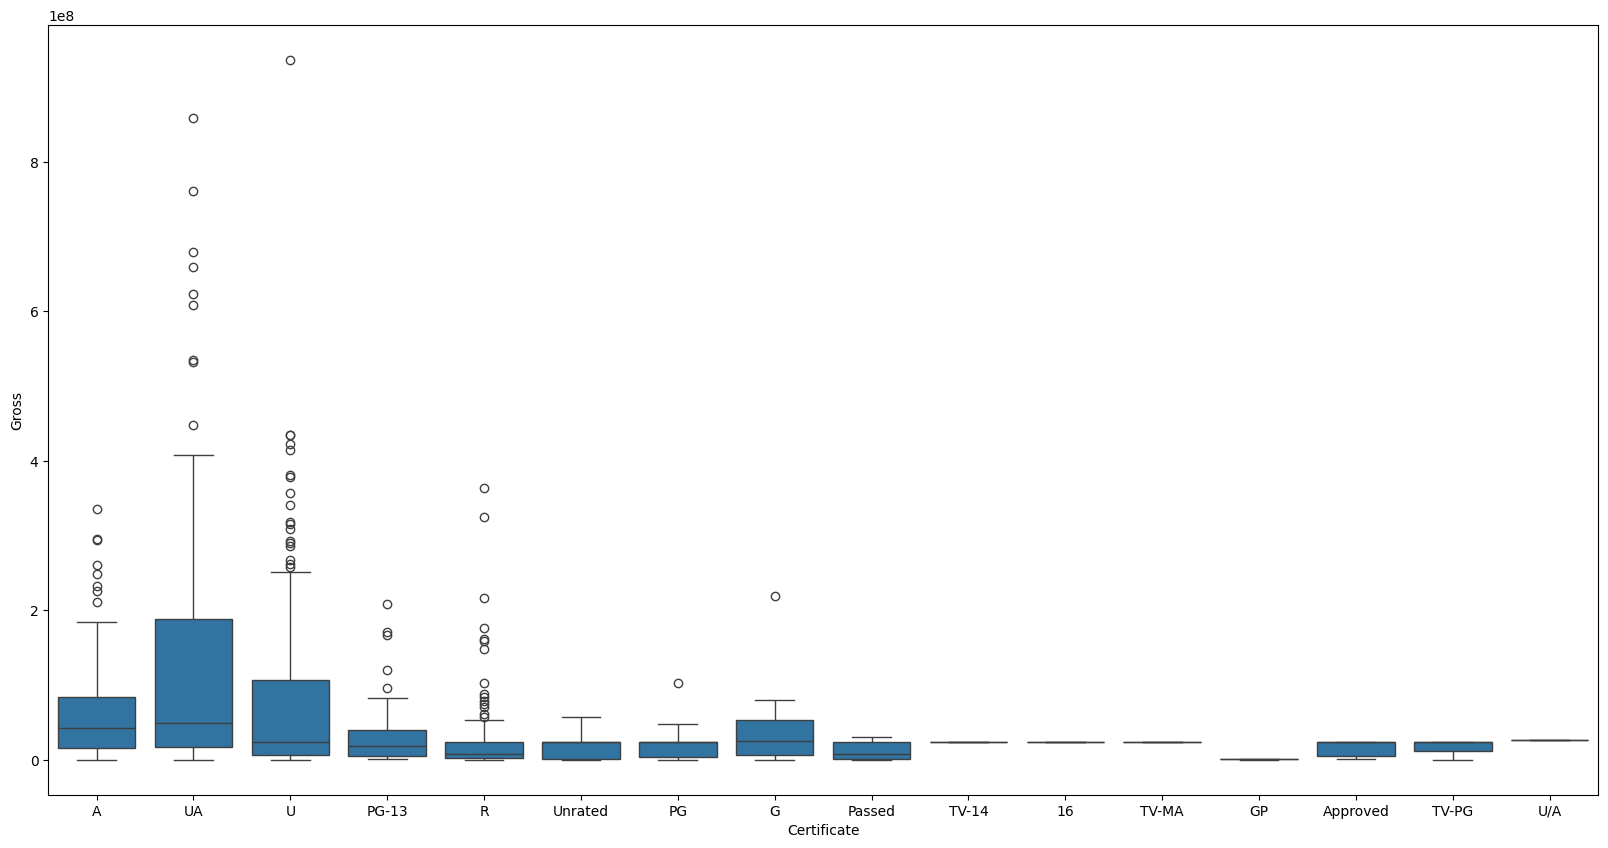

In [50]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_limpo, x='Certificate', y='Gross')
plt.xlabel('Certificate')
plt.ylabel('Gross')
plt.show()

## c. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna Overview permite extrair temas e palavras-chave que indicam determinados gêneros, também pode ser usada em análises de sentimento para identificar o tom emocional da narrativa e com técnicas de Processamento de Linguagem Natural (PLN), pode servir como variável preditiva para inferir gênero, popularidade ou recomendar filmes semelhantes, além disso, ajuda a entender tendências narrativas ao longo do tempo, mostrando como os temas do cinema evoluem.

É possível inferir o gênero de um filme a partir da coluna Overview, desde que esse texto seja tratado de forma adequada por meio de técnicas de Processamento de Linguagem Natural, que envolve a limpeza dos dados, remoção de palavras irrelevantes, lematização e tokenização, após essa etapa, é possível extrair informações mais estruturadas por meio de CountVectorizer ou TF-IDF, que transformam o texto em vetores numéricos que representam a frequência e importância de cada termo. Com as informações vetorizadas, pode-se então aplicar modelos de classificação supervisionada, como Random Forest, Naive Bayes ou mesmo algoritmos de redes neurais.

# 3. Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Por se tratar de um problema de previsão de uma variável numérica e continua, ele foi tratado como um problema regressivo. Foi necessário preparar os dados, Algumas variáveis numéricas, como Released_Year, Runtime, Meta_score, No_of_Votes e Gross, foram mantidas porque fazem sentido no contexto, época de lançamento, duração do filme, avaliação da crítica, popularidade e a bilheteria podem impactar a percepção do público direta, indiretamente ou como consequência. Para reduzir distorções Gross e No_of_Votes foram transformados com logaritmo para diminuir a assimetria, também foi necessário tirar ',' de Gross para trata-la como numérica, e valores ausentes em Meta_score e Gross foram preenchidos pela mediana.

As variáveis categóricas, como Certificate, Genre, Director e Star1–Star4, também foram incluídas porque representam o perfil do conteúdo e dos profissionais envolvidos, que podem impactar a nota devido sua fama e qualidade de serviço. Nos modelos lineares, elas foram transformadas em dummies, enquanto no CatBoost puderam ser utilizadas diretamente como strings, já que o algoritmo lida naturalmente com variáveis categóricas e valores faltantes. Campos irrelevantes ou redundantes, como título do filme e sinopse, foram descartados porque não eram adequados ao escopo do modelo sem técnicas avançadas de NLP.

Avaliamos inicialmente algoritmos lineares, como Regressão Linear, Ridge e Lasso. Esses modelos têm como vantagem a simplicidade, rapidez no treinamento e maior interpretabilidade, no entanto apresentaram limitações claras na captura de relações mais complexas entre as variáveis, o que resulta em um desempenho mais modesto. Além dos algoritmos lineares também testamos o CatBoost, um modelo de gradiente boosting que se mostrou muito mais eficiente nesse contexto, além de lidar nativamente com variáveis categóricas e valores ausentes, ele conseguiu capturar interações e não-linearidades que os modelos lineares não alcançaram. O resultado foi um desempenho significativamente superior, com menores erros e maior capacidade explicativa. A principal desvantagem do CatBoost é a menor interpretabilidade e o maior custo de processamento, mas, pelo seu desempenho, ele foi considerado a melhor escolha para o problema.

Para avaliar o desempenho, utilizamos o RMSE como métrica principal porque o RMSE fornece o erro médio na mesma escala da nota do IMDb e penaliza de forma mais intensa erros grandes, o que é fundamental em um cenário em que diferenças de décimos já podem alterar bastante a percepção sobre um filme. Além do RMSE foi observado o MAE e o R^2, para uma visão mais ampla da performance dos modelos.

A previsão do IMDb foi melhor resolvida pelo CatBoost que trouxe o equilíbrio ideal entre robustez, flexibilidade e qualidade preditiva.

# 4. Supondo um filme com as seguintes características, Qual seria a nota do IMDB?:

A nota seria 8,85, o que é muito próxima da nota real 9,3


**obs:** aqui estou usando as mesmas instruções de uso que deixei readme então para rodar tem que ter o arquivo pkl




In [51]:
#Estou salvando aqui para não haver enganos
joblib.dump(final_model_cat, "final_model_cat.pkl")

['final_model_cat.pkl']

In [52]:

# Carregar modelo
model = joblib.load("final_model_cat.pkl")

#Criar função que ira utilizar o modelo
def prever_nota_imdb(filme_dict, modelo):

    num_cols = ["Released_Year", "Runtime", "Meta_score", "No_of_Votes", "Gross"]
    cat_cols = ["Certificate", "Genre", "Director", "Star1", "Star2", "Star3", "Star4"]

    ordered_cols = num_cols + cat_cols

    df = pd.DataFrame([filme_dict])

    # Pré-processamento
    df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
    df["Runtime"] = df["Runtime"].str.replace(" min", "", regex=False).astype(float)
    df["Gross"] = df["Gross"].astype(str).str.replace(",", "", regex=False).astype(float)
    df["No_of_Votes"] = np.log1p(df["No_of_Votes"])
    df["Gross"] = np.log1p(df["Gross"])

    # Categorias como string
    for c in cat_cols:
        if c not in df.columns:
            df[c] = ""
    df[cat_cols] = df[cat_cols].fillna("NA").astype(str)

    # Reordenar colunas
    df = df[ordered_cols]

    # Índices das colunas categóricas
    cat_idx = [ordered_cols.index(c) for c in cat_cols]

    pool = Pool(
        data=df,
        cat_features=cat_idx,
        feature_names=ordered_cols
    )

    pred = modelo.predict(pool)
    return float(pred[0])


In [53]:
filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469.0
}
# Transformar em DataFrame
filme_df = pd.DataFrame([filme])

predicao = prever_nota_imdb(filme, model)
print(f"Predição de nota IMDB: {predicao:.2f}")


Predição de nota IMDB: 8.85


# 5. Salve o modelo desenvolvido no formato .pkl

In [54]:
joblib.dump(final_model_cat, "model_imdb.pkl")

['model_imdb.pkl']

# 6. A entrega deve ser feita através de um repositório de código público quecontenha:

a. README explicando como instalar e executar o projeto

b. Arquivo de requisitos com todos os pacotes utilizados e suas versões

c. Relatórios das análises estatísticas e EDA em PDF, Jupyter Notebook
ou semelhante conforme passo 1 e 2.

d. Códigos de modelagem utilizados no passo 3 (pode ser entregue no
mesmo Jupyter Notebook).

e. Arquivo .pkl conforme passo 5 acima.

Todos os códigos produzidos devem seguir as boas práticas de codificação.